# Exploratory Data Anlysis Using Youtube Data Videos from Most Popular Indian Spirituality Channels

## 1. Aims, Objectives, Steps & Background

### 1.1 Introduction

With millions of users and billions of views, YouTube has become a major platform for spirituality content creators to share their knowledge and insights with a global audience. However, understanding what makes a video successful on YouTube can be a challenge, as the platform's algorithm is complex and constantly evolving. Aspiring spirituality content creators can benefit from analyzing successful channels in their niche and identifying trends in their topics and presentation styles. In this project, we will explore the statistics
of 9 popular spirituality channels on YouTube to gain insights on their audience, content, and engagement metrics.

### 1.2 Aims and Objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?

- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
- Which questions are being asked in the comment sections in the videos

### 1.3 Steps of the project

- Obtain video meta data via the API app, from top 10 youtube niche channels.
- Preprocess data and engineer aditional features for analysis
- Exploratory data analysis
- Conclusions

### 1.4 Dataset

- Created my own dataset usign the Google API version 3.0
- The channels are included as per my liking and self-thoughts about spirituality.
- Also I have chosen channels based on their subscriber counts.

## Library Imports

In [2]:
import pandas as pd
import os
import numpy as np
from dateutil import parser
import isodate
import datetime

# Data visualization libraries
import matplotlib
# matplotlib.use('TkAgg') #default backend 'module://matplotlib_inline.backend_inline'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.font_manager as fm
import seaborn as sns
sns.set(style = 'darkgrid', color_codes=True)
#plt.rcParams['font.family'] = 'Lohit-Devanagari'
#plt.rcParams["font.path"] = "/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"
english_font = fm.FontProperties(family = 'Arial', size = 14)
#mangal_font = fm.FontProperties(fname = "~/downloads/fonts/mangal.ttf",size = 14)
#%matplotlib inline
#NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

# Google API
from googleapiclient.discovery import build

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yuvi_dh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yuvi_dh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Creation with Youtube API

- Created a project on Google Developer Console
- Requested an Authorization Credential API Key
- Enabled Youtube API for the project work to send API requests to Youtube API services.
- Got the channel ID's from my favorite channels which I would like to get stats on.
- Finally created the functions for getting the channel stats.

In [ ]:
import os
api_key_1 = os.environ.get('yt_1')
api_key_2 = os.environ.get('yt_2')
api_key_3 = os.environ.get('yt_3')
api_key_4 =os.environ.get('db_api_1')
api_key_5 =os.environ.get('db_api_1')
api_key_6 =os.environ.get('db_api_1')
api_key_7 =os.environ.get('db_api_1')
api_key_8 =os.environ.get('db_api_1')
api_key = api_key_1

#Auto Channel ID's
channel_ids = """UCXXBi6rvC-u8VDZRD23F7tw
UCFfFgeKVVhjXtQSXRj3e-Iw
UCoV2Qw0sL-ApYQ62k-88K1w
UCPJ61cXBMjpjyCcb5OhUzEg
UClbYzBq_iCnk4Vg4HF1MhfQ
UCj_ARBxhCoF5JxUItcEUs7Q
 UCvh0vLzlZ8fFoedB6O3vluw
UCuxpxCCevIlF-k-K5YU8XPA
UCes1EvRjcKU4sY_UEavndBw
UCL6JmiMXKoXS6bpP1D3bk8g""".split('\n')
youtube = build('youtube', 'v3',developerKey=api_key)

In [ ]:
(channel_ids), (len(channel_ids))

### Functions

In [ ]:
def get_channel_stats(channel_ids,yt=youtube):
    '''
    Get Channel statistics: title subscriber count, view count, video count, upload playlist

    Params:
    youtube: the build object from googleapiclient.discovery
    channel_ids: list of channel IDs

    Returns:
    Dataframe containing the channel statistics for all channels in the provided list

    '''
    all_data = []
    request = youtube.channels().list(
        part = 'snippet,contentDetails,statistics,brandingSettings',
        id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    # countryName = response['items'][i]['snippet']["country"],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'],
                   publishedAt = isodate.parse_datetime(response['items'][i]['snippet']['publishedAt']))

        all_data.append(data)
    return pd.DataFrame(all_data)

In [ ]:
def get_video_ids(playlist_id, max_results=1000,yt = youtube):
    """
    Get list of video IDs of all videos in the given playlist, up to a maximum of 1500 videos
    Params:

    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    max_results: maximum number of videos to retrieve (default: 1500)

    Returns:
    List of video IDs of all videos in the playlist, up to the maximum number of videos specified

    """

    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = min(max_results, 50))
    response = request.execute()

    video_ids = []
    num_videos = 0

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        num_videos += 1
        if num_videos >= max_results:
            break

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages and num_videos < max_results:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = min(max_results - num_videos, 50),
                        pageToken = next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
                num_videos += 1
                if num_videos >= max_results:
                    break

            next_page_token = response.get('nextPageToken')

    return video_ids

In [ ]:
def get_video_details(video_ids,yt = youtube):
    """
    Get video statistics of all videos with given IDs
    Params:

    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs

    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'commentCount'
        'duration', 'definition', 'caption'
    """

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [ ]:
def get_comments_in_videos(video_ids, yt = youtube):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:

    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs

    Returns:
    Dataframe with video IDs and associated top level comment in text.

    """
    all_comments = []

    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)

        except:
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

### Get Channel statistics

Using the get_channel_stats function defined below, now we are going to obtain the channel statistics for the above channels in scope

In [ ]:
channel_data = get_channel_stats(channel_ids)
channel_data.to_csv("./autos/top_autos_info.csv")

In [ ]:
channel_data

In [8]:
# Creation of copy so that I save a dummy df and also a csv, to not keep reusing youtube credits i.e. 10k per day.
l_channel_data = pd.read_csv("./autos/top_autos_info.csv",index_col=0)
l_channel_data

,channelName,subscribers,views,totalVideos,playlistId,publishedAt
0,Doctor D.S.,2220000,568464343,356,UUPJ61cXBMjpjyCcb5OhUzEg,2016-09-29 14:20:36+00:00
1,STAR GAMERS,4550000,660915190,2150,UUvh0vLzlZ8fFoedB6O3vluw,2020-05-26 03:14:19.645406+00:00
2,DailyDrivenExotics,3880000,1432713994,1874,UUj_ARBxhCoF5JxUItcEUs7Q,2013-01-24 04:14:25+00:00
3,MEDCARS,1320000,544091970,832,UUFfFgeKVVhjXtQSXRj3e-Iw,2015-03-11 19:15:48+00:00
4,Scotty Kilmer,6020000,2573884582,5609,UUuxpxCCevIlF-k-K5YU8XPA,2007-08-19 13:12:23+00:00
5,Need for Speed,1300000,148849558,65,UUXXBi6rvC-u8VDZRD23F7tw,2006-02-08 22:47:00+00:00
6,Hot Wheels,3760000,2834950075,2995,UUlbYzBq_iCnk4Vg4HF1MhfQ,2005-12-06 14:46:56+00:00
7,ChrisFix,9950000,1639839120,389,UUes1EvRjcKU4sY_UEavndBw,2008-07-30 14:59:12+00:00
8,DIY Garage,2100000,400824909,28,UUoV2Qw0sL-ApYQ62k-88K1w,2017-01-18 22:01:32+00:00
9,Donut,8380000,2538575661,1509,UUL6JmiMXKoXS6bpP1D3bk8g,2015-07-09 18:57:30+00:00


In [9]:
# Copy used for further manipulation and original of l_channel_data can be used to load this chdd any time.
chdd = l_channel_data.copy()
chdd

,channelName,subscribers,views,totalVideos,playlistId,publishedAt
0,Doctor D.S.,2220000,568464343,356,UUPJ61cXBMjpjyCcb5OhUzEg,2016-09-29 14:20:36+00:00
1,STAR GAMERS,4550000,660915190,2150,UUvh0vLzlZ8fFoedB6O3vluw,2020-05-26 03:14:19.645406+00:00
2,DailyDrivenExotics,3880000,1432713994,1874,UUj_ARBxhCoF5JxUItcEUs7Q,2013-01-24 04:14:25+00:00
3,MEDCARS,1320000,544091970,832,UUFfFgeKVVhjXtQSXRj3e-Iw,2015-03-11 19:15:48+00:00
4,Scotty Kilmer,6020000,2573884582,5609,UUuxpxCCevIlF-k-K5YU8XPA,2007-08-19 13:12:23+00:00
5,Need for Speed,1300000,148849558,65,UUXXBi6rvC-u8VDZRD23F7tw,2006-02-08 22:47:00+00:00
6,Hot Wheels,3760000,2834950075,2995,UUlbYzBq_iCnk4Vg4HF1MhfQ,2005-12-06 14:46:56+00:00
7,ChrisFix,9950000,1639839120,389,UUes1EvRjcKU4sY_UEavndBw,2008-07-30 14:59:12+00:00
8,DIY Garage,2100000,400824909,28,UUoV2Qw0sL-ApYQ62k-88K1w,2017-01-18 22:01:32+00:00
9,Donut,8380000,2538575661,1509,UUL6JmiMXKoXS6bpP1D3bk8g,2015-07-09 18:57:30+00:00


In [10]:
# Setting Numeric n Categorical columns
numeric_cols = ['subscribers','views','totalVideos']
chdd[numeric_cols] = chdd[numeric_cols].apply(pd.to_numeric,errors = 'coerce')

# Convert publishedAt column to datetime
chdd['publishedAt'] =(pd.to_datetime(chdd['publishedAt']))

# Extract year, month, and time into separate columns
chdd['publishingYear'] = chdd['publishedAt'].dt.year
chdd['publishingMonth'] = chdd['publishedAt'].dt.month
chdd['publishingTime'] = chdd['publishedAt'].dt.time

# Get month name
chdd['publishingMonthName'] = chdd['publishedAt'].dt.strftime("%B")

# Dropping the published At column
chdd.drop(['publishedAt'],axis = 1, inplace = True)

In [11]:
chdd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   channelName          10 non-null     object
 1   subscribers          10 non-null     int64 
 2   views                10 non-null     int64 
 3   totalVideos          10 non-null     int64 
 4   playlistId           10 non-null     object
 5   publishingYear       10 non-null     int64 
 6   publishingMonth      10 non-null     int64 
 7   publishingTime       10 non-null     object
 8   publishingMonthName  10 non-null     object
dtypes: int64(5), object(4)
memory usage: 800.0+ bytes


### Popularity measure via the number of subscribers per channel

In [12]:
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

In [ ]:
#matplotlib.use??
#sns.barplot??

In [13]:
# Fixing colors for each channel
palette = plt.cm.tab10.colors[:10]
channel_colors = {}
chdd.sort_values('subscribers',ascending=False,inplace=True)
for i, channel in enumerate(chdd['channelName']):
    channel_colors[channel] = palette[i]

In [ ]:
#matplotlib.use??

/tmp/ipykernel_10070/1435573863.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


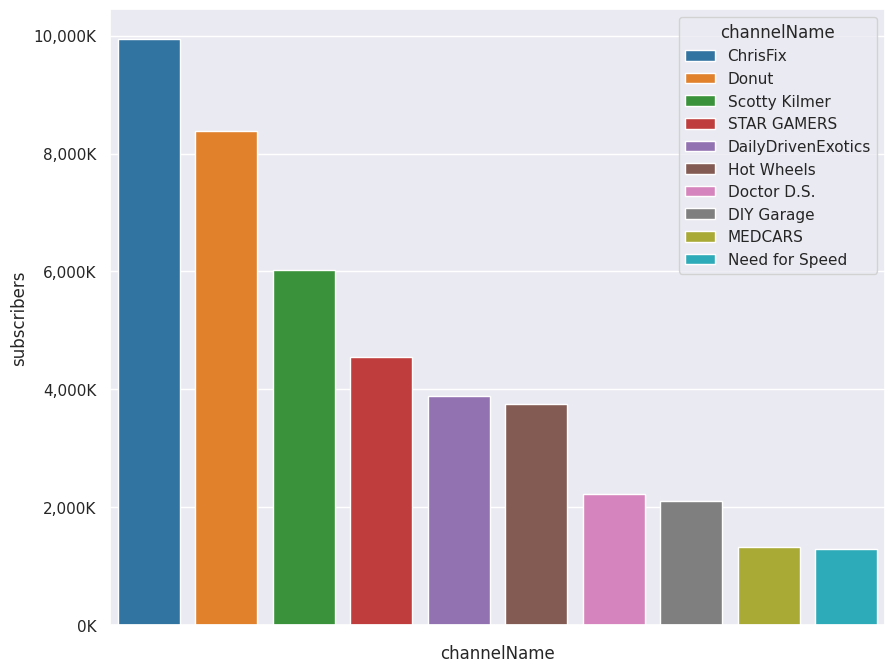

In [14]:
#matplotlib.use('module://matplotlib_inline.backend_inline')
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName',hue = 'channelName', y='subscribers', data=chdd.sort_values('subscribers', ascending=False), palette=channel_colors, legend = True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Popularity measure via the number of views per channel

/tmp/ipykernel_10070/3728265254.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


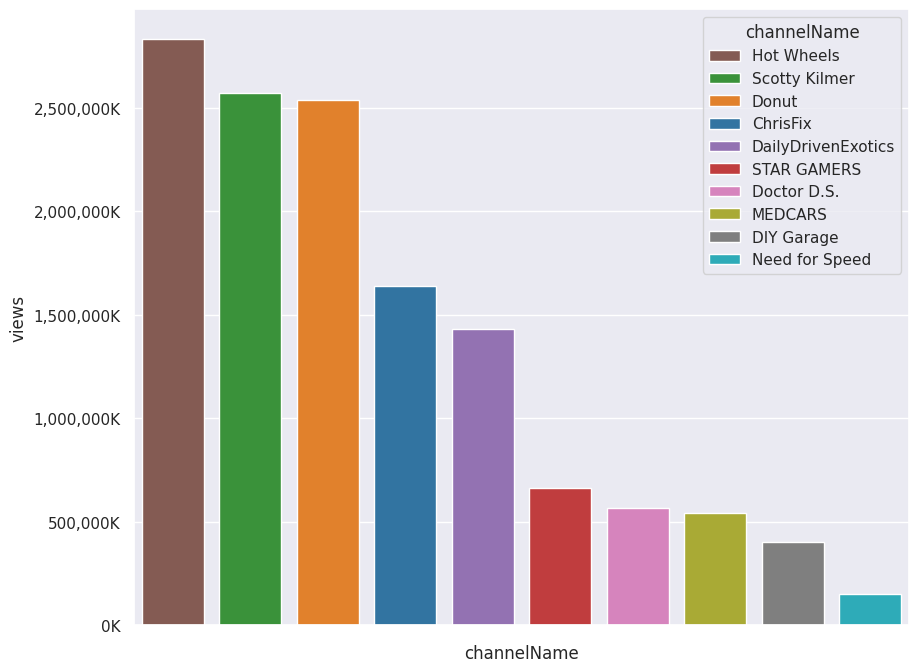

In [15]:
ax = sns.barplot(x = 'channelName', hue='channelName', y='views', data=chdd.sort_values('views', ascending=False),palette=channel_colors, legend = True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

#### Observation from above stats:
- Interestingly, some channels have more subscribers but less views and vice versa. For example, GGD channel has significantly more subscribers than Mind Valley channel, but less views in total.
- Psych2Go and The School of Life hold onto their ranks in both views and subscriber count

### Get video statistics for all the channels

In the next step, we will obtain the video statistics for all the channels. In total, we obtained 3,722 videos as seen in below.

In [ ]:
# Create a dataframe with video statistics and comments from all channels
video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(playlist_id,max_results=1000,yt = youtube)

    # get video data
    video_data = get_video_details(video_ids,yt = youtube)
    # get comment data
    comments_data = get_comments_in_videos(video_ids,yt = youtube)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

In [ ]:
video_df.to_csv("./autos/top_autos_vid.csv")
comments_df.to_csv("./autos/top_autos_comments.csv")

In [16]:
l_video_df = pd.read_csv("./autos/top_autos_vid.csv",index_col=0)
l_comments_df = pd.read_csv("./autos/top_autos_comments.csv",index_col=0)

In [17]:
viddf = l_video_df.copy()
comdf = l_comments_df.copy()

In [18]:
# Create publish day (in the week) column
viddf['publishedAt'] =  viddf['publishedAt'].apply(lambda x: parser.parse(x))
viddf['pushblishDayName'] = viddf['publishedAt'].apply(lambda x: x.strftime("%A"))

# Convert publishedAt column to datetime
viddf['publishedAt'] =(pd.to_datetime(viddf['publishedAt']))


# Extract year, month, and time into separate columns
viddf['publishingYear'] = viddf['publishedAt'].dt.year
viddf['publishingMonth'] = viddf['publishedAt'].dt.month
viddf['publishingTime'] = viddf['publishedAt'].dt.time

# Get month name
viddf['publishingMonthName'] = viddf['publishedAt'].dt.strftime("%B")

# Dropping the published At column
viddf.drop(['publishedAt'],axis = 1, inplace = True)

In [ ]:
viddf

Let's take a look at the comment_df as well. We only get 9305 comments in total due to the fact that we limited to 10 first comments on the video to avoid exceeding the Youtube API quota limit.

In [19]:
comdf

,video_id,comments
0,jeakKn-Nxls,"['Exhaust outside, no smell. 😂', 'A potom pri..."
1,jT9njAeab1s,['Not buying that there was no smoke or smell ...
2,hpcvymrLyMw,"['gran coupe', 'Po mom misljenju to je jedan o..."
3,df3juiU_-ns,"['Iskreno, kao neko sličnih interesovanja i sp..."
4,vhxY4TdPLec,"['Can i have a bite?', 'Sepertinya enak😋']"
...,...,...
5665,HRm9UIunRJM,"['cheaser looks ugly', 'I had a 1997 Toyota ch..."
5666,bYn2wAK-CYE,['Damn I wish we had this available on the eas...
5667,N3ZqAG7CE8E,['Definitely not an accurate review at all. Fo...
5668,BzTT2sIbtVc,"['IM GONNA BE PART OF DA RIOT', 'In forza hori..."


## Preprocessing & Feature Engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics. Also I removed the favorite count column as it's completely blank

### Check for empty values

In [20]:
viddf.isnull().sum(axis = 0)

video_id                  0
channelTitle              0
title                     0
description             108
tags                   1702
viewCount                 0
likeCount                 1
commentCount              0
duration                  0
definition                0
caption                   0
pushblishDayName          0
publishingYear            0
publishingMonth           0
publishingTime            0
publishingMonthName       0
dtype: int64

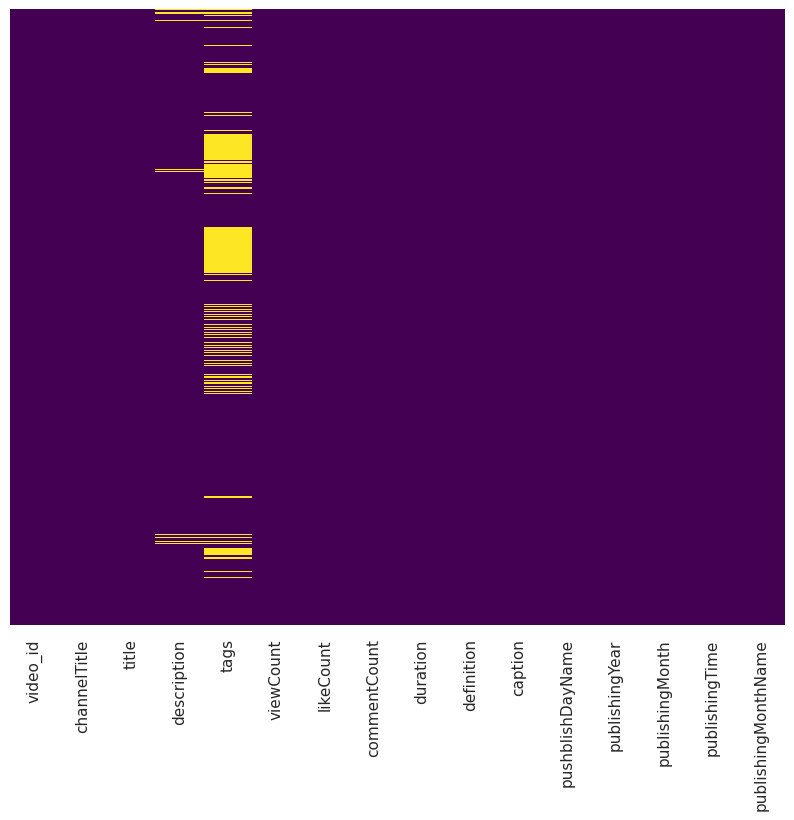

In [21]:
sns.heatmap(viddf.isnull(),yticklabels = False, cbar = False, cmap = 'viridis')
plt.show()

### Formatting Dates

In [ ]:
viddf.publishingYear.sort_values().value_counts()
# Videos are from 2011 to 2023
#- During the covid time the channels became more active it seems over all.

### Correcting Data types


In [22]:
cols = ['viewCount', 'likeCount', 'commentCount']
viddf[cols] = viddf[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#### Enriching data

I want to enrich the data for further analyses, for example:
- convert video duration to seconds instead of the current default string format
- calculate number of tags for each video
- calculate comments and likes per 1000 view ratio
- calculate title character length

In [23]:
# convert duration to seconds
viddf['durationSecs'] = viddf['duration'].apply(lambda x: isodate.parse_duration(x))
viddf['durationSecs'] = viddf['durationSecs'].astype('timedelta64[s]')

In [24]:
# Add number of tags
viddf['tagsstr'] = viddf.tags.apply(lambda x: 0 if x is None else str((x))) #tags were not in proper format so converting them to str
viddf['tagsCount'] = viddf.tagsstr.apply(lambda x: 0 if (x == 0 or x =='nan') else len(eval(x)))

In [25]:
# Comments and likes per 1000 view ratio
viddf['likeRatio'] = viddf['likeCount']/ viddf['viewCount'] * 1000
viddf['commentRatio'] = viddf['commentCount']/ viddf['viewCount'] * 1000

In [26]:
# Title character length
viddf['titleLength'] = viddf['title'].apply(lambda x: len(x))

In [ ]:
# Dropping the favourite Count as all of it is empty
# viddf.drop(['favouriteCount'],axis = 1, inplace=True)

Taking a look at the dataset

## Exploratory Analysis

### Views distribution per channel

With the video statistics for all channel, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Few channels like Gaeia, Vishuddha Das, might have more evenly distribution views per video.

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # Create a MinMaxScaler object
# scaler = MinMaxScaler()
# dfd = viddf.copy()
# # Normalize the viewCount and likeCount columns it didn't help much in plotting cause every value was transformed relatively so used the dynamic plotting to view the plots
# dfd[['viewCount', 'likeCount']] = scaler.fit_transform(dfd[['viewCount', 'likeCount']])
# dfd

In [ ]:
# matplotlib.use("TkAgg")

/tmp/ipykernel_10070/3189328019.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='channelTitle', y='viewCount', data=viddf.sort_values('viewCount', ascending=False), palette = channel_colors)
/tmp/ipykernel_10070/3189328019.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


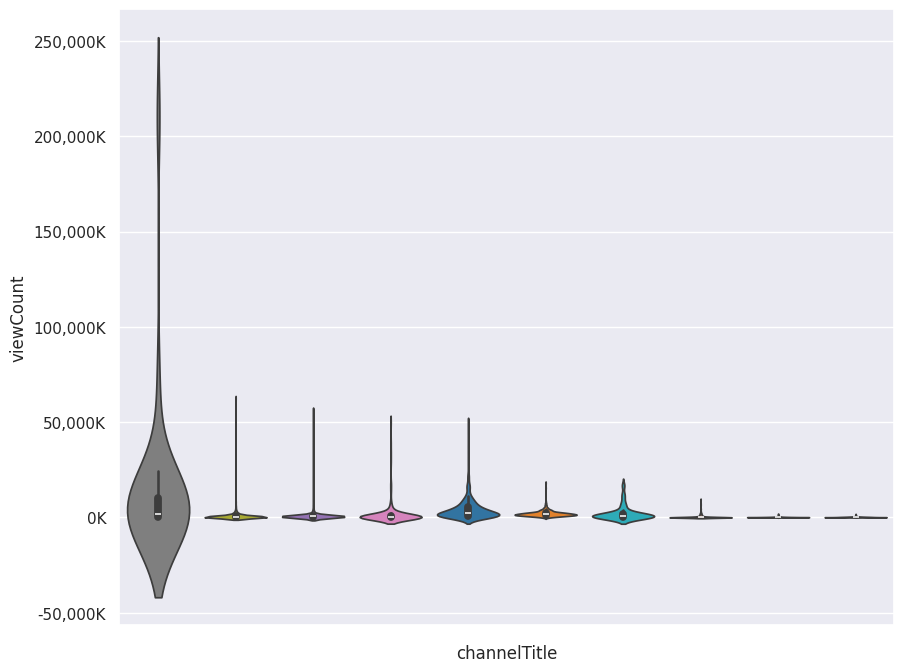

In [27]:
sns.set(rc={'figure.figsize':(10,8),'figure.dpi':100})
ax = sns.violinplot(x='channelTitle', y='viewCount', data=viddf.sort_values('viewCount', ascending=False), palette = channel_colors)
# ax.set_ylim(ymin= 1e-9,ymax=1e9)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

In [ ]:
# print(matplotlib.rcsetup.all_backends)

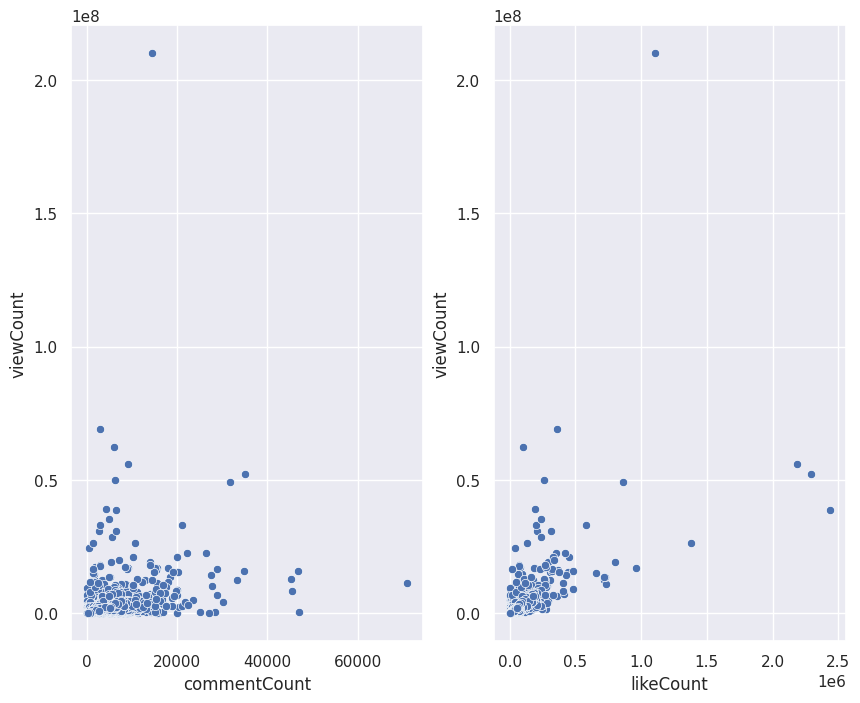

In [28]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = viddf, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = viddf, x = "likeCount", y = "viewCount", ax=ax[1])
plt.show()

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number. It seems that more views is leading to more comments and more likes as well, but after a certain point I think, with views viewers, don't write comments that much.

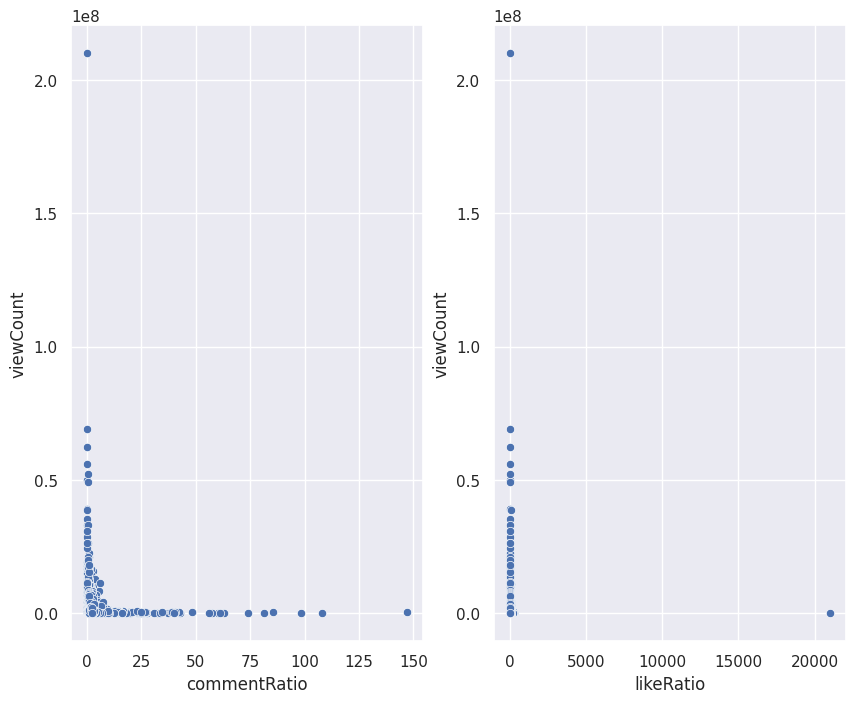

In [29]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = viddf, x = "commentRatio", y = "viewCount", ax=ax[0])
#ax[0].set_ylim(0,9e6)
#ax[1].set_ylim(0,9e6)
sns.scatterplot(data = viddf, x = "likeRatio", y = "viewCount", ax=ax[1])
plt.show()

### Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 1600 to 1800 seconds, which is about 20 to 30 minutes. Here I have to limit the duration to 10,000 because of some really long videos (potentially streaming videos).

In [ ]:
#sns.histplot??

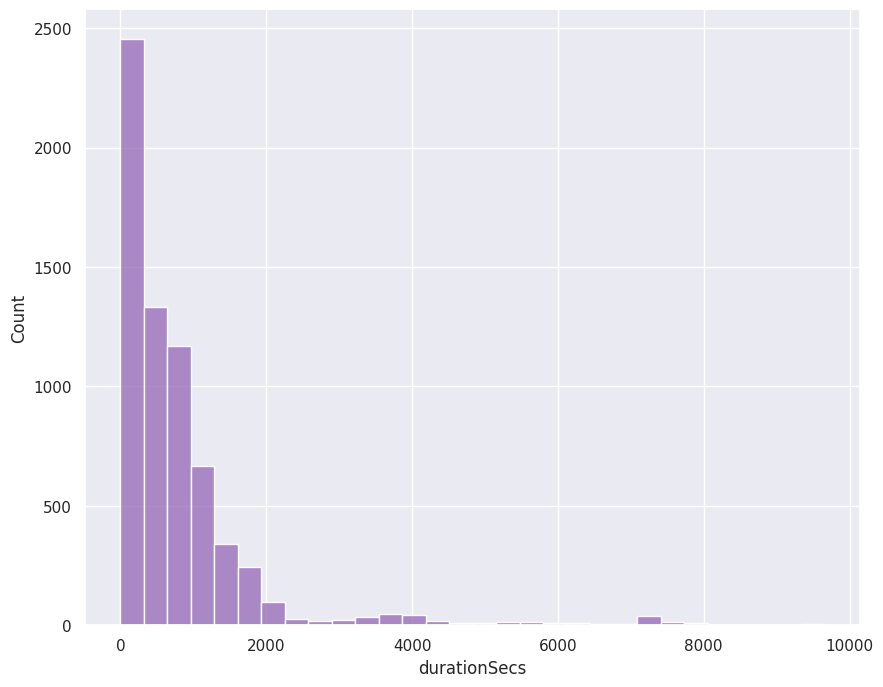

In [30]:
sns.histplot(data=viddf[viddf['durationSecs'] < 10000], x="durationSecs", bins=30, color="#9368b7")
plt.show()

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

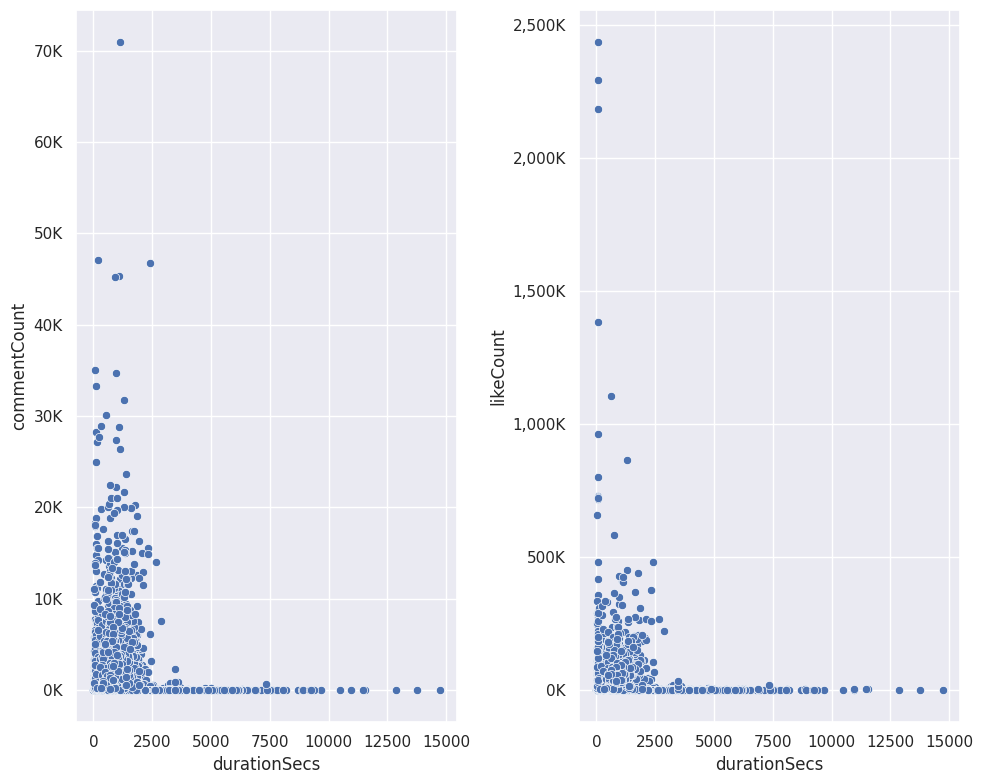

In [31]:
fig, ax =plt.subplots(1,2)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = viddf, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = viddf, x = "durationSecs", y = "likeCount", ax=ax[1])
#ax[0].set_ylim(0,1e5)
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
#ax[1].set_ylim(0,1e5)
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
fig.tight_layout()
plt.show()

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 35-60 characters

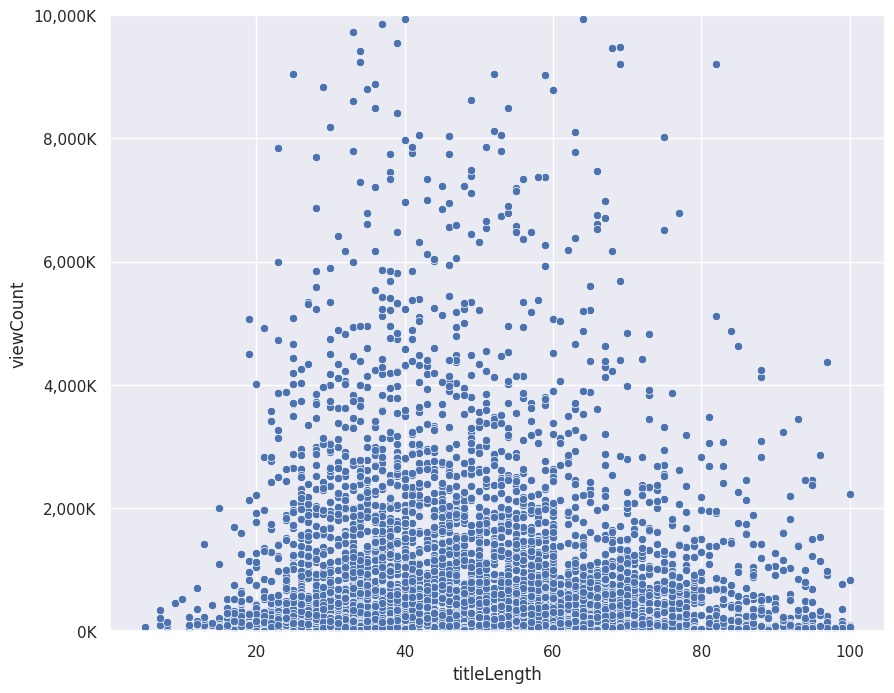

In [32]:
ax = sns.scatterplot(data = viddf, x = "titleLength", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_ylim(0,1e7)
plt.show()

## Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you", "I", "the", etc. which do note contribute a lot to the meaning of the title. It can be seen that the main words posted in title are Life, Attraction, Love, Meditation, People and Thing.

In [ ]:
stop_words = set(stopwords.words('english'))
viddf['title_no_stopwords'] = viddf['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in viddf['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

In [ ]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 1920, height = 780, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)
plt.show()

In [ ]:
# sorted(wordcloud.words_.items(), key = lambda x: x[1],reverse = False)

### Number of tags vs views

It seems that most videos have between 10 and 45 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

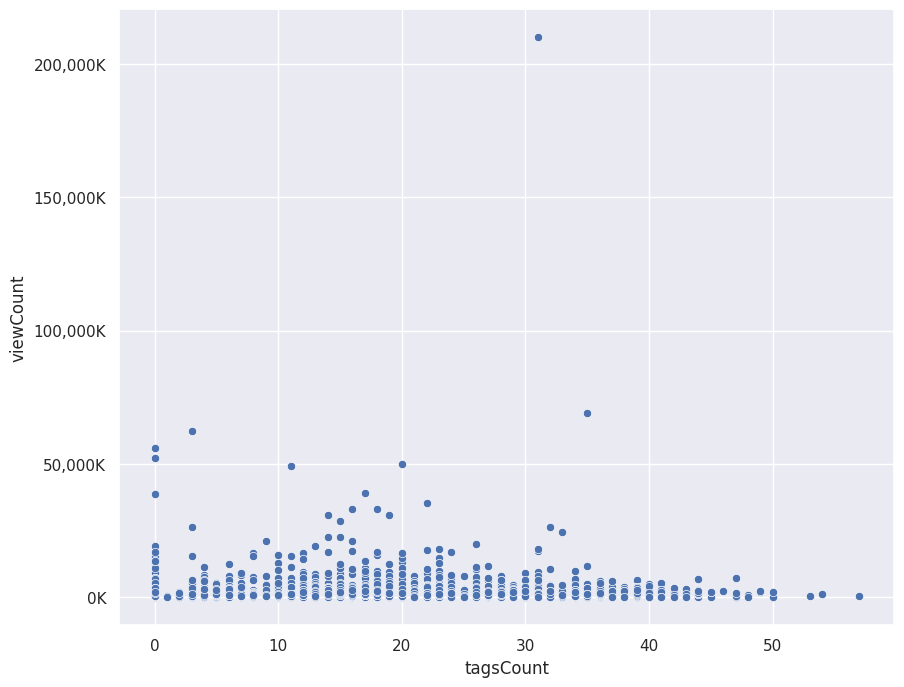

In [33]:
plot = sns.scatterplot(data = viddf, x = "tagsCount", y = "viewCount")
plot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.show()

### Which day in the week are most videos uploaded

It's interesting to see that more videos are uploaded on Mondays, Wednesdays and Fridays. It seems the pattern is alternative in uploading the videos. This might be because of maintaining a consistency on channel, like when the user can more expect the videos, on a consistent basis.

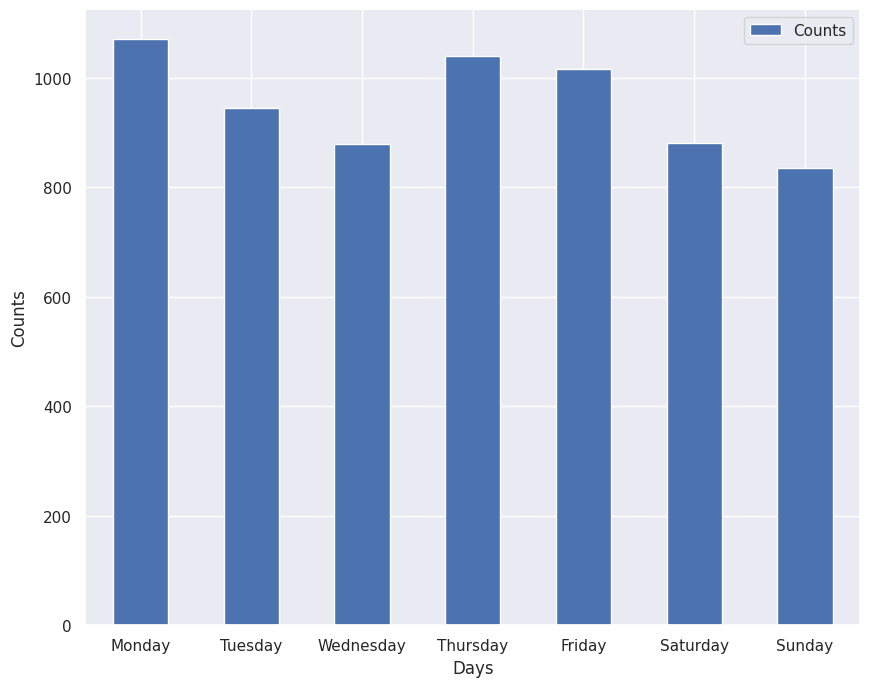

In [34]:
day_df = pd.DataFrame(viddf['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)
plt.xlabel("Days")
plt.ylabel("Counts")
plt.legend(labels = ["Counts"])
plt.show()

## Wordcloud for video comments

In [ ]:
stop_words = set(stopwords.words('english'))
comdf['comments_no_stopwords'] = comdf['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comdf['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

In [ ]:
wordcloud = WordCloud(width = 1980, height = 720, random_state=1, background_color='black',
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)
plt.show()